# Parsing Reports

This notebook parses the contents of reports/ to understand the speed and reliability of AGC-running experiments. It is meant to parse the reports generated by xcache_testing.ipynb, or similar analysis-running notebooks. Each of the following links under "Shortcuts" is an example of how to use the class `ParsedReport`, which is defined just below in this notebook. The class takes as input the path to the `pkl` file created, for example, in the second to last cell of xcache_testing.ipynb.

Shortcuts:

- [Remote Reading, Max 5 Files per Sample](#remote_max5)
- [XCache, Max 5 Files per Sample (First)](#xcache_max5_first)
- [XCache, Max 5 Files per Sample (Second)](#xcache_max5_second)
- [Remote Reading, All Files](#remote_all)
- [XCache, All Files (First)](#xcache_all_first)
- [XCache, All Files (Second)](#xcache_all_second)
- [XCache01, All Files (First)](#xcache01_all_first)
- [XCache01, All Files (Second)](#xcache01_all_second)
- [XCache, All Files (Redone)](#xcache_all_redo)
- [Purdue XCache, All Files (First)](#Purduexcache_all_first)
- [XCache03, All Files (First)](#xcache03_all_first)
- [XCache03, All Files (Second)](#xcache03_all_second)
- [XCache05, All Files (First)](#xcache05_all_first)
- [XCache05, All Files (Second)](#xcache05_all_second)

In order to use the class in this notebook, you have to run the following cell of import statements, as well as the cell that defines the `ParsedReport` class.

In [1]:
import awkward as ak
import pickle as pkl
import matplotlib.pyplot as plt
import hist

In [2]:
REMOTE_NONE_NONE = "RemoteRead_reports20240822_221923_250_None_None.pkl"
REMOTE_5_NONE = "RemoteRead_reports20240822_202120_250_5_None.pkl"
XCACHE_5_NONE_FIRST = "Xcache_reports20240822_204219_250_5_None.pkl"
XCACHE_5_NONE_SECOND = "Xcache_reports20240822_205535_250_5_None.pkl"
XCACHE_NONE_NONE_FIRST = "Xcache_reports20240823_192620_250_None_None.pkl"
XCACHE_NONE_NONE_SECOND = "Xcache_reports20240829_183753_250_None_None.pkl"
XCACHE01_NONE_NONE_FIRST = "Xcache01_reports20240927_151811_250_None_None.pkl"
XCACHE01_NONE_NONE_SECOND = "Xcache01_reports20240927_154645_250_None_None.pkl"
XCACHE03_NONE_NONE_FIRST = "Xcache03_reports20241022_171222_250_None_None.pkl"
XCACHE03_NONE_NONE_SECOND = "Xcache03_reports20241022_180931_250_None_None.pkl"
XCACHE05_NONE_NONE_FIRST = "Xcache05_reports20241104_220636_250_None_None.pkl"
XCACHE05_NONE_NONE_SECOND = "Xcache05_reports20241111_162908_250_None_None.pkl"
XCACHE_NONE_NONE_REDO = "Xcache_reports20240927_165356_250_None_None.pkl"
PURDUE_XCACHE_NONE_NONE_FIRST = "PurdueXcache_reports20240930_141505_250_None_None.pkl"

## ParsedReport Class

The following cell is code for a class that parses the reports generated by dask in `xcache_testing.ipynb`, or the main analysis pipeline notebook.

In [3]:
class ParsedReport:
    def __init__(self,rep):
        with open(rep,"rb") as f:
            self.reports = pkl.load(f)
        self.errors = {}
        for dset in self.reports.keys():
            self.errors[dset] = self.reports[dset][~ak.is_none(self.reports[dset].message)]

        #Calculate some aggregate metrics
        self._chunk_fail_rate()
        self._count_chunks()
        self._file_fail_rate()
        self._count_files()
        self._count_sites()
        self._count_messages()

    def print_metrics(self,sites=False):
        print("AGGREGATE INFO:\n----------------------------------------------------")
        print(f"Total number of files: {self.num_files}")
        print(f"Total file read error rate: {100*self.tot_file_fail_rate}%")
        print(f"Total number of chunks: {self.num_chunks}")
        print(f"Total chunk read error rate: {100*self.tot_chunk_fail_rate}%")
        
        print("\n========================================================\n")
        print("PER-DATASET INFO:\n----------------------------------------------------")
        for dset in self.reports.keys():
            print(f"Dataset: {dset}")
            print(f"\tNumber of files: {len(set(self.reports[dset].args[:,0]))}")
            print(f"\tFile read error rate: {100*self.file_fail_rates[dset]}%")
            print(f"\tNumber of chunks: {ak.num(self.reports[dset],axis=0)}")
            print(f"\tChunk read error rate: {100*self.chunk_fail_rates[dset]}%")
        print("\n========================================================\n")
        print("ERROR MESSAGES:\n----------------------------------------------------")
        for msg in self.messages:
            print(f"Error message: {msg}")
            print(f"\tChunks with this message: {self.messages_count[msg]}")
        if not sites:
            return
        print("\n========================================================\n")
        print("SITES INFO:\n----------------------------------------------------")
        for site in self.site_counts.keys():
            print(f"Site: {site}")
            print(f"\tNumber of files: {self.site_counts[site]}")
            print(f"\tFile read failure rate at this site: {100*self.site_error_counts[site]/self.site_counts[site]}%")

    def _chunk_fail_rate(self):
        self.chunk_fail_rates = {}
        for dset in self.reports.keys():
            self.chunk_fail_rates[dset] = ak.num(self.errors[dset],axis=0)/ak.num(self.reports[dset],axis=0)

    def _count_chunks(self):
        self.num_chunks = 0
        self.num_error_chunks = 0
        for dset in self.reports.keys():
            self.num_chunks += ak.num(self.reports[dset],axis=0)
            self.num_error_chunks += ak.num(self.errors[dset],axis=0)
        self.tot_chunk_fail_rate = self.num_error_chunks/self.num_chunks

    def _file_fail_rate(self):
        self.file_fail_rates = {}
        for dset in self.reports.keys():
            num_files = len(set(self.reports[dset].args[:,0]))
            num_error_files = len(set(self.errors[dset].args[:,0]))
            self.file_fail_rates[dset] = num_error_files/num_files

    def _count_files(self):
        self.num_files = 0
        self.num_error_files = 0
        for dset in self.reports.keys():
            self.num_files += len(set(self.reports[dset].args[:,0]))
            self.num_error_files += len(set(self.errors[dset].args[:,0]))
        self.tot_file_fail_rate = self.num_error_files/self.num_files

    def _count_sites(self):
        self.site_counts = {}
        self.site_error_counts = {}
        for dset in self.reports.keys():
            files = set(self.reports[dset].args[:,0])
            for f in files:
                file_count = ak.sum((self.reports[dset].args[:,0] == f) & (self.reports[dset].args[:,2] == "0"))
                error_file_count = ak.sum((self.errors[dset].args[:,0] == f) & (self.errors[dset].args[:,2] == "0"))
                site = f.split('/store')[0]
                self.site_counts[site] = self.site_counts.get(site,0) + file_count
                self.site_error_counts[site] = self.site_error_counts.get(site,0) + error_file_count
                

    def _count_messages(self):
        _messages_list = []
        for dset in self.errors.keys():
            _messages_list += list(set(self.errors[dset].message))
        _messages_set = set(_messages_list)
        self.messages = ak.str.trim(ak.Array(_messages_set),'\n')
        self.messages_count = {}
        for dset in self.errors.keys():
            if ak.num(self.errors[dset].message,axis=0) == 0:
                continue
            for msg in _messages_set:
                if msg[-1] == '\n':
                    msg_clean = msg[:-1]
                else:
                    msg_clean = msg
                self.messages_count[msg_clean] = self.messages_count.get(msg_clean,0) + ak.sum(self.errors[dset].message == msg)

    def sites_piechart(self,group_small=False):
        """
        If group_small, gather all sites with 0% failure and accounting for < 3% of total files into one group.
        """
        THRESHOLD = 0.03
        sites = []
        counts = []
        other = 0
        for site,count in self.site_counts.items():
            if group_small and (self.site_counts[site]/self.num_files < THRESHOLD) and (self.site_error_counts[site] == 0):
                other += self.site_counts[site]
                continue
            sites.append(site+f" ({100*self.site_error_counts[site]/self.site_counts[site]:.1f}%)")
            counts.append(count)

        if group_small:
            sites.append("Other (0%)")
            counts.append(other)

        fig,ax = plt.subplots()
        ax.set_title("Files per Site\nLabeling: Site (Failure Rate per Site)")
        ax.pie(counts,labels=sites)

    def msg_hist(self):
        messages = []
        sites = []
        for infos in self.errors.values():
            messages += list(infos.message)
            sites += list(ak.str.split_pattern(infos.args[:,0],'/store')[:,0])

        site_axis = hist.axis.StrCategory(set(sites),growth=False,name="sites")
        msg_axis = hist.axis.StrCategory(set(messages),growth=False,name="msg")
        h = hist.Hist(site_axis,msg_axis)
        h.fill(sites=sites,msg=messages)
        fig,ax = plt.subplots()
        ax.tick_params(axis='x',labelrotation=90)
        h.plot()

## Parsing Reports

## Results for Remote Reading, Max 5 Files per Sample

<a id='remote_max5'></a>

In [46]:
rep1 = ParsedReport(f"reports/{REMOTE_5_NONE}")

In [47]:
rep1.print_metrics(sites=True)

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 40
Total file read error rate: 2.5%
Total number of chunks: 3209
Total chunk read error rate: 4.799002804612028%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 532
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 292
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 503
	Chunk read err

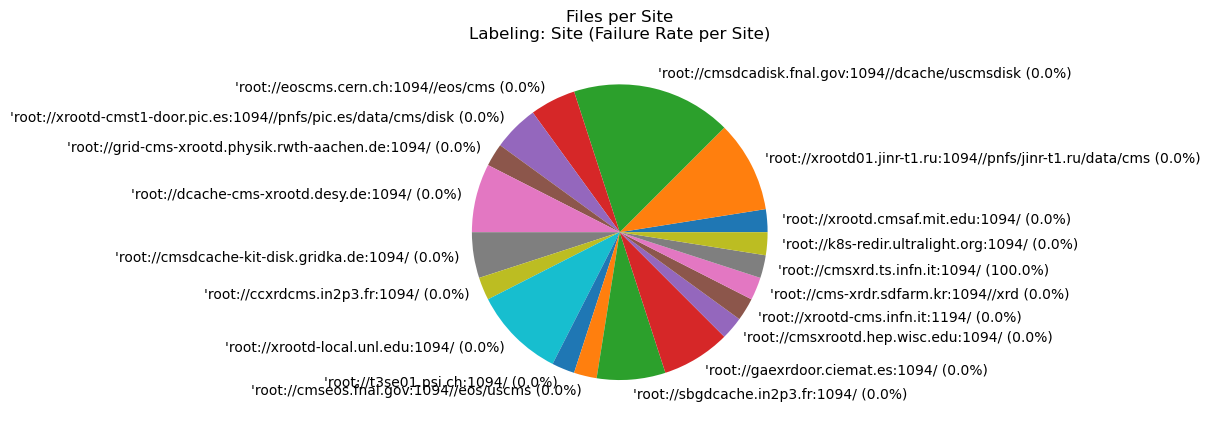

In [48]:
rep1.sites_piechart()

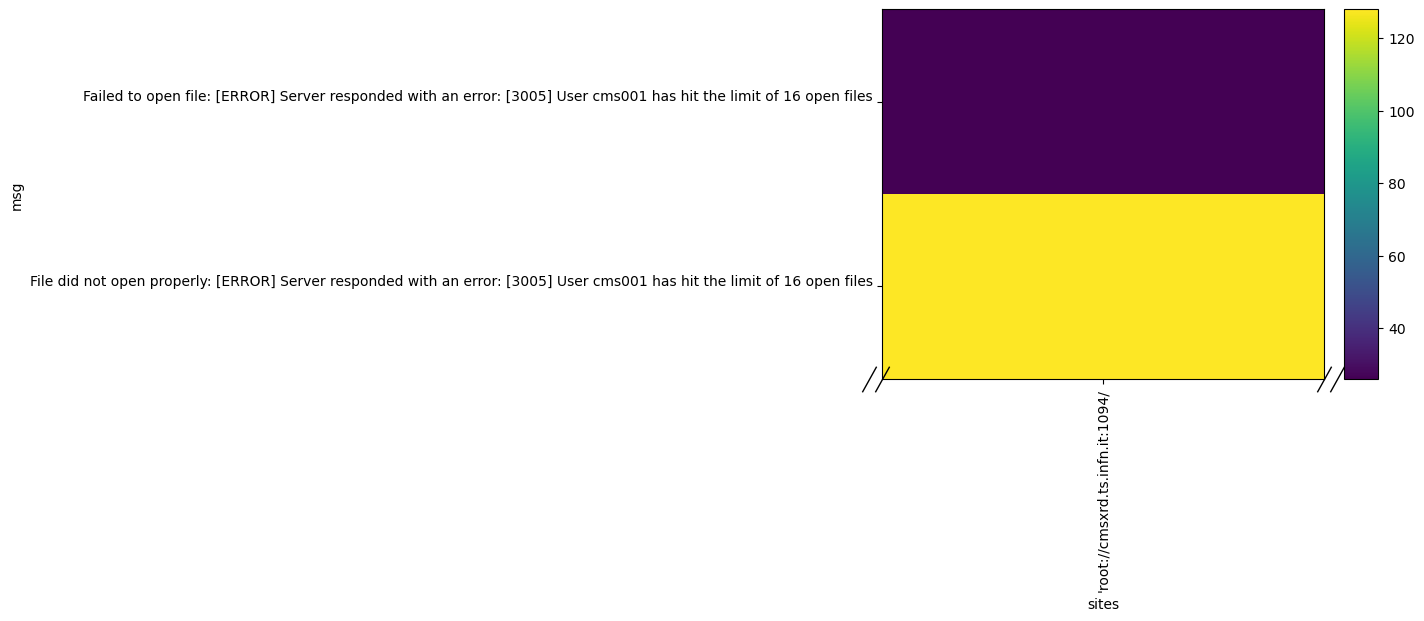

In [49]:
rep1.msg_hist()

## Results for XCache Reading, Max 5 Files per Sample, Files not yet in XCache

<a id='xcache_max5_first'></a>

In [50]:
rep2 = ParsedReport(f"reports/{XCACHE_5_NONE_FIRST}")

In [51]:
rep2.print_metrics(sites=True)

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 40
Total file read error rate: 2.5%
Total number of chunks: 3209
Total chunk read error rate: 2.243689622935494%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 532
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 292
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 503
	Chunk read err

## Results for XCache Reading, Max 5 Files per Sample, Files already in XCache

<a id='xcache_max5_second'></a>

In [52]:
rep3 = ParsedReport(f"reports/{XCACHE_5_NONE_SECOND}")

In [53]:
rep3.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 40
Total file read error rate: 2.5%
Total number of chunks: 3209
Total chunk read error rate: 2.243689622935494%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 532
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 292
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 5
	File read error rate: 0.0%
	Number of chunks: 503
	Chunk read err

## Results for Remote Reading, All Files All Chunks

<a id='remote_all'></a>

In [50]:
rep4 = ParsedReport(f"reports/{REMOTE_NONE_NONE}")

In [51]:
rep4.print_metrics(sites=True)

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 4.981773997569866%
Total number of chunks: 79735
Total chunk read error rate: 3.620743713551138%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 3.0395136778115504%
	Number of chunks: 31863
	Chunk read error rate: 0.7343941248470013%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read e

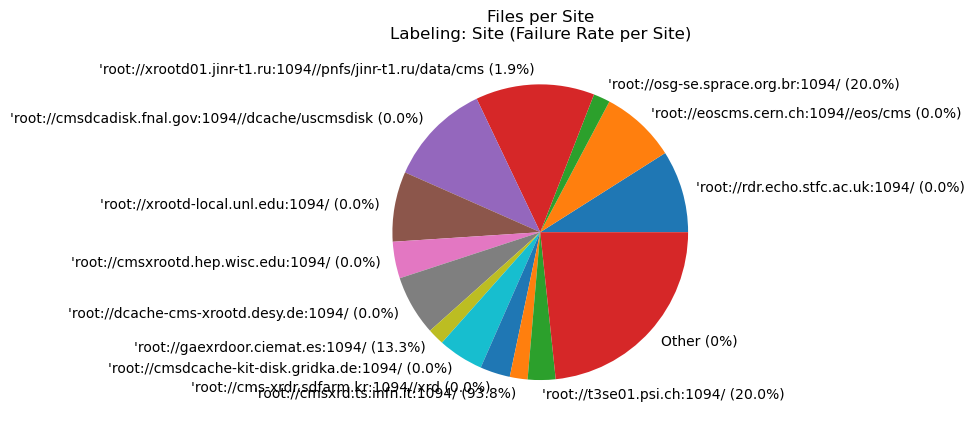

In [52]:
rep4.sites_piechart(group_small=True)

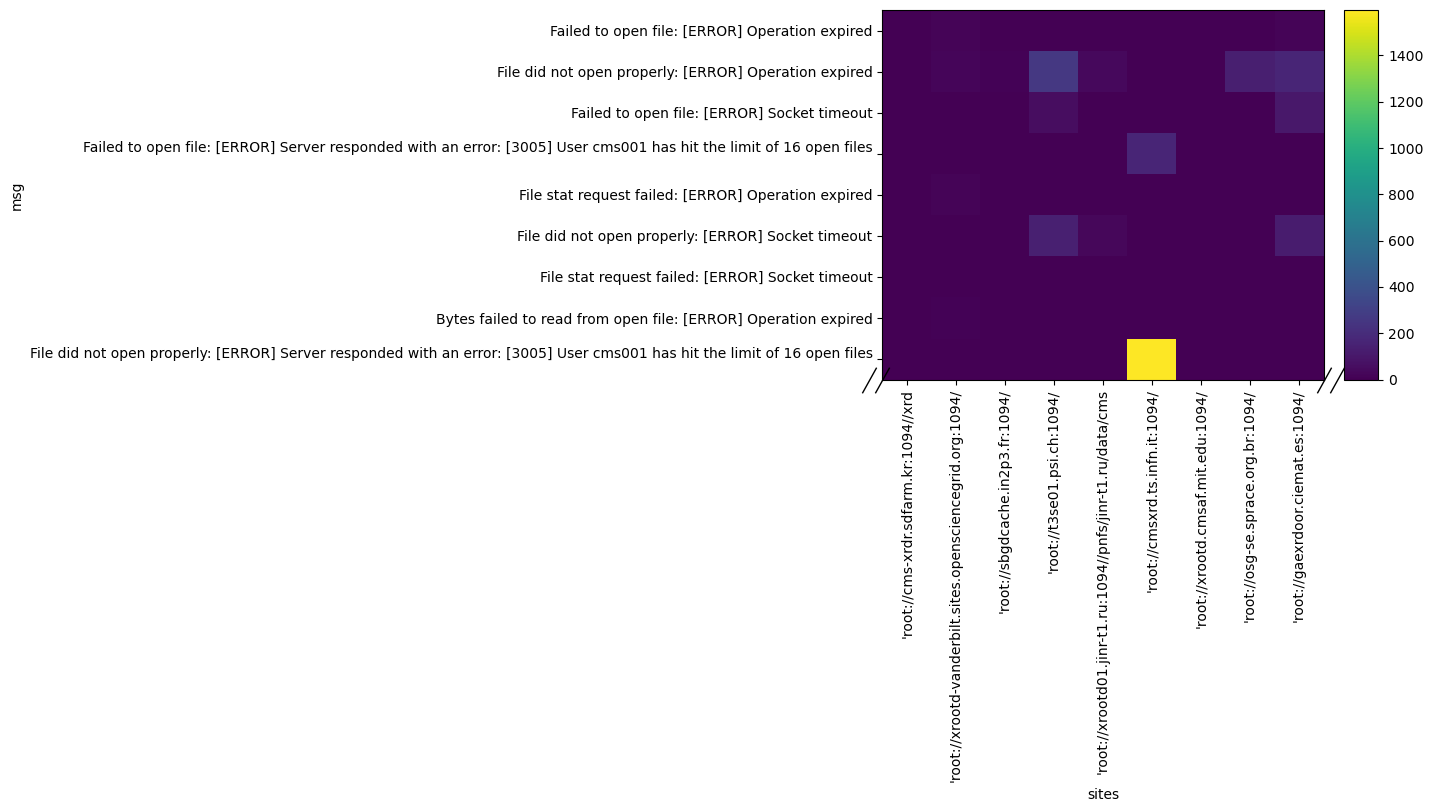

In [53]:
rep4.msg_hist()

## Results for XCache Reading, All Files All Chunks

<a id='xcache_all_first'></a>

In [56]:
rep5 = ParsedReport(f"reports/{XCACHE_NONE_NONE_FIRST}")

In [57]:
rep5.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 13.365735115431349%
Total number of chunks: 79735
Total chunk read error rate: 10.410735561547627%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 17.325227963525837%
	Number of chunks: 31863
	Chunk read error rate: 14.116687066503466%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 6.666666666666667%
	Number of chunks: 1627
	Chunk read error rate: 16.65642286416718%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Num

## Results for XCache Reading, All Files, Files already in XCache

<a id='xcache_all_second'></a>

In [5]:
rep6 = ParsedReport(f"reports/{XCACHE_NONE_NONE_SECOND}")

In [6]:
rep6.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 37.78857837181045%
Total number of chunks: 79735
Total chunk read error rate: 6.210572521477394%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 56.53495440729483%
	Number of chunks: 31863
	Chunk read error rate: 11.926058437686345%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 60.0%
	Number of chunks: 1627
	Chunk read error rate: 30.11677934849416%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 12

## Results for XCache01 Reading, All Files

<a id='xcache01_all_first'></a>

In [4]:
rep7 = ParsedReport(f"reports/{XCACHE01_NONE_NONE_FIRST}")

In [5]:
rep7.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.12150668286755771%
Total number of chunks: 79735
Total chunk read error rate: 0.09280742459396751%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.303951367781155%
	Number of chunks: 31863
	Chunk read error rate: 0.23224429589178672%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File re

## Results for XCache01 Reading, All Files, Files Already in XCache01

<a id='xcache01_all_second'></a>

In [11]:
rep8 = ParsedReport(f"reports/{XCACHE01_NONE_NONE_SECOND}")

In [12]:
rep8.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.0%
Total number of chunks: 79735
Total chunk read error rate: 0.0%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.0%
	Number of chunks: 31863
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read error rate: 0.0%
	Number of chunks: 15117
	Chunk read error

## Results for XCache Reading, All Files, Redoing after XCache01 Test

<a id='xcache_all_redo'></a>

In [13]:
rep9 = ParsedReport(f"reports/{XCACHE_NONE_NONE_REDO}")

In [14]:
rep9.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 26.24544349939247%
Total number of chunks: 79735
Total chunk read error rate: 4.0270897347463475%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 48.02431610942249%
	Number of chunks: 31863
	Chunk read error rate: 9.189341869880426%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 3.3333333333333335%
	Number of chunks: 1627
	Chunk read error rate: 0.06146281499692685%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Num

## Results for XCache Reading, All Files All Chunks

<a id='Purduexcache_all_first'></a>

In [6]:
rep10 = ParsedReport(f"reports/{PURDUE_XCACHE_NONE_NONE_FIRST}")

In [7]:
rep10.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.3645200486026731%
Total number of chunks: 79735
Total chunk read error rate: 0.20693547375681948%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.911854103343465%
	Number of chunks: 31863
	Chunk read error rate: 0.517842011110065%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read 

## Results for XCache03 Reading, All Files

<a id='xcache03_all_first'></a>

In [8]:
rep11 = ParsedReport(f"reports/{XCACHE03_NONE_NONE_FIRST}")

In [9]:
rep11.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.12150668286755771%
Total number of chunks: 79735
Total chunk read error rate: 0.0012541543864049663%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.0%
	Number of chunks: 31863
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read error rate: 0.0%
	Number 

## Results for XCache03 Reading, All Files, Second Time (Files in Cache)

<a id='xcache03_all_second'></a>

In [13]:
rep12 = ParsedReport(f"reports/{XCACHE03_NONE_NONE_SECOND}")

In [14]:
rep12.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.12150668286755771%
Total number of chunks: 79735
Total chunk read error rate: 0.0012541543864049663%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.0%
	Number of chunks: 31863
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read error rate: 0.0%
	Number 

## Results for XCache05 Reading, All Files

<a id='xcache05_all_first'></a>

In [4]:
rep13 = ParsedReport(f"reports/{XCACHE05_NONE_NONE_FIRST}")

In [5]:
rep13.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.7290400972053462%
Total number of chunks: 79735
Total chunk read error rate: 0.3875337053991347%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 0.0%
	Number of chunks: 31863
	Chunk read error rate: 0.0%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 0.0%
	Number of chunks: 1627
	Chunk read error rate: 0.0%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 124
	File read error rate: 0.0%
	Number of c

## Results for XCache05 Reading, All Files (Files Already in XCache05)

<a id='xcache05_all_second'></a>

In [4]:
rep14 = ParsedReport(f"reports/{XCACHE05_NONE_NONE_SECOND}")

In [5]:
rep14.print_metrics()

AGGREGATE INFO:
----------------------------------------------------
Total number of files: 823
Total file read error rate: 0.6075334143377886%
Total number of chunks: 79735
Total chunk read error rate: 0.20944378252962942%


PER-DATASET INFO:
----------------------------------------------------
Dataset: /TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAOD-106X_upgrade2018_realistic_v11_L1v1-v1/NANOAODSIM
	Number of files: 329
	File read error rate: 1.21580547112462%
	Number of chunks: 31863
	Chunk read error rate: 0.5084267018171547%
Dataset: /ST_s-channel_4f_hadronicDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	Number of files: 30
	File read error rate: 3.3333333333333335%
	Number of chunks: 1627
	Chunk read error rate: 0.30731407498463426%
Dataset: /ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM
	N